# This Notebook will develop how to build an Agent and assess its performance.
Try me out interactively with: [![Binder](./img/badge_logo.svg)](https://mybinder.org/v2/gh/rte-france/Grid2Op/master)

**Objective**

This notebook will cover the basics of the information that can be retrieved about the state of the powergrid.

Examples of "expert agents" that can take actions based on some fixed rules, will be given for illustration purpose. More generic types of *Agents*, relying for example on machine learning / deep learning will be covered in the notebook [04_TrainingAnAgent](04_TrainingAnAgent.ipynb).

This notebook will also cover the description of the *Observation* class, which is useful to take some actions.

In [1]:
import os
import sys
import numpy as np
import grid2op

# TODO explain the methods to get the "graph" of the grid
# and the kirchoff law too (sum of the bus matrix)

In [2]:
res = None
try:
    from jyquickhelper import add_notebook_menu
    res = add_notebook_menu()
except ModuleNotFoundError:
    print("Impossible to automatically add a menu / table of content to this notebook.\nYou can download \"jyquickhelper\" package with: \n\"pip install jyquickhelper\"")
res

## I) Description of the observations

**NB** In this paragraph we will cover the observation class. For more information about it, we recommend to have a look at the official documentation, or [here](https://grid2op.readthedocs.io/en/latest/observation.html) or in the [Observations.py](grid2op/Observation/Observation.py) files for more information. Only basic concepts are detailed in this notebook.

### I.A) Getting an observation

An observation can be accessed by calling `env.step()`. The next cell is dedicated to creating an environment and getting an observation instance. We use the default `rte_case14_realistic` environment from Grid2Op framework.

In [3]:
env = grid2op.make(test=True)
obs = env.reset() 

c:\users\benja\documents\grid2op_dev\grid2op\MakeEnv\Make.py:273: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


`obs` now contains the initial state of the grid.

### I.B) Information contained in an Observation

In this notebook we will detail only the "CompleteObservation". `Grid2Op` allows to model different kinds of observations. For example, some observations could have incomplete data, or noisy data, etc. `CompleteObservation` gives the full state of the powergrid, without any noise. It's the default type of observation used.

#### a) Some of its attributes

An observation has calendar data (eg the time stamp of the observation):

In [4]:
obs.year, obs.month, obs.day, obs.hour_of_day, obs.minute_of_hour, obs.day_of_week

(2019, 1, 6, 0, 0, 6)

It has some powergrid generic information (that are static: the same environment has always these attributes, that have always the same values, but of course different environments can have different values)

In [5]:
print("Number of generators of the powergrid: {}".format(obs.n_gen))
print("Number of loads of the powergrid: {}".format(obs.n_load))
print("Number of powerline of the powergrid: {}".format(obs.n_line))
print("Number of elements connected to each substations in the powergrid: {}".format(obs.sub_info))
print("Total number of elements: {}".format(obs.dim_topo))

Number of generators of the powergrid: 5
Number of loads of the powergrid: 11
Number of powerline of the powergrid: 20
Number of elements connected to each substations in the powergrid: [3 6 4 6 5 6 3 2 5 3 3 3 4 3]
Total number of elements: 56


It has some information about the generators (each generator can be viewed as a point in a 3-dimensional space)

In [6]:
print("Generators active production: {}".format(obs.gen_p))
print("Generators reactive production: {}".format(obs.gen_q))
print("Generators voltage setpoint : {}".format(obs.gen_v))

Generators active production: [74.8      73.8      29.2       0.       75.578995]
Generators reactive production: [ 19.329943  74.27505   43.9601    24.940077 -17.105919]
Generators voltage setpoint : [142.1      142.1       22.        13.200001 142.1     ]


It has some information about the loads (each load is a point in a 3-dimensional space, too)

In [7]:
print("Loads active consumption: {}".format(obs.load_p))
print("Loads reactive consumption: {}".format(obs.load_q))
print("Loads voltage (voltage magnitude of the bus to which it is connected) : {}".format(obs.load_v))

Loads active consumption: [22.4 87.4 47.   6.9 11.6 30.1  8.9  3.3  5.4 12.5 14.1]
Loads reactive consumption: [15.6 60.9 32.2  4.9  8.1 21.1  6.2  2.4  3.8  8.7 10. ]
Loads voltage (voltage magnitude of the bus to which it is connected) : [142.1      142.1      138.8432   139.63824   22.        21.046211
  21.052515  21.43466   21.575861  21.423473  20.71459 ]


In this setting, a powerline can be viewed as a point in an 8-dimensional space:
   * active flow
   * reactive flow
   * voltage magnitude
   * current flow
   
for both its origin and its extremity.

For example, suppose the powerline `line1` is connecting two node `A` and `B`. There are two separate values for the active flow on `line1` : the active flow from `A` to `B` (origin) and the active flow from `B` to `A` (extremity).

These powerline features can be accessed with :

In [8]:
print("Origin active flow: {}".format(obs.p_or))
print("Origin reactive flow: {}".format(obs.q_or))
print("Origin current flow: {}".format(obs.a_or))
print("Origin voltage (voltage magnitude to the bus to which the origin end is connected): {}".format(obs.v_or))
print("Extremity active flow: {}".format(obs.p_ex))
print("Extremity reactive flow: {}".format(obs.q_ex))
print("Extremity current flow: {}".format(obs.a_ex))
print("Extremity voltage (voltage magnitude to the bus to which the origin end is connected): {}".format(obs.v_ex))

Origin active flow: [ 4.0707798e+01  3.4871201e+01  2.5377020e+01  3.7496193e+01
  2.9901894e+01  1.1478888e+01 -3.3143944e+01  1.3214905e+01
  8.0508566e+00  1.9815624e+01 -7.1048772e-01  4.8118830e+00
 -9.6106367e+00  2.5566595e+00  9.5292444e+00  2.1781700e+01
  1.2419695e+01  2.3481386e+01  1.0214052e-14 -2.1781700e+01]
Origin reactive flow: [-15.569891    -1.5360277   -7.6821265    0.76632917  -0.3415194
   9.081002    -3.0429037    9.386731     5.2836905   14.365451
  -0.12496944   4.2011113   -6.3253665    1.2876393    6.294099
 -14.952104    -2.2230313   -5.5788174  -24.034567    -7.1806583 ]
Origin current flow: [177.08029  141.81856  107.72723  152.3783   121.498886  59.468212
 138.40173  425.38623  252.71758  642.3019    19.789661 175.2324
 315.52786   76.60076  307.76926  109.86134   52.46547   99.788956
 935.0104   629.15857 ]
Origin voltage (voltage magnitude to the bus to which the origin end is connected): [142.1      142.1      142.1      142.1      142.1      142.1
 1

Another powerline feature is the $\rho$ ratio, *ie.* for each powerline, the ratio between the current flow in the powerline and its thermal limit. It can be accessed with:

In [9]:
obs.rho

array([0.4600681 , 0.3684554 , 0.2834927 , 0.40099552, 0.7738783 ,
       0.15649529, 0.36421508, 0.39470926, 0.5471496 , 0.8343746 ,
       0.07345007, 0.45526716, 0.41516823, 0.20158096, 0.40495956,
       0.28542814, 0.22718215, 0.58424634, 0.2748218 , 0.18492466],
      dtype=float32)

The observation (*obs*) also stores information on the topology and the state of the powerline.

In [10]:
obs.timestep_overflow # the number of timestep each of the powerline is in overflow (1 powerline per component)
obs.line_status # the status of each powerline: True connected, False disconnected
obs.topo_vect  # the topology vector the each element (generator, load, each end of a powerline) to which the object
# is connected: 1 = bus 1, 2 = bus 2.

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In `grid2op`, all objects (end of a powerline, load or generator) can be either disconnected, connected to the first bus of its substation, or connected to the second bus of its substation.

`topo_vect` is the vector containing the connection information, it is part of the observation.
If an object is disconnected, then its corresponding component in `topo_vect` will be `-1`. If it's connected to the first bus of its substation, its component will be `1` and if it's connected to the second bus, its component will be `2`.

For example, if you want to know at which bus the "load 2" is connected, you can do:

In [11]:
load_id = 2
obs.topo_vect[obs.load_pos_topo_vect[load_id]]

1

Or alternatively

In [12]:
obs.load_bus[load_id]

1

**NB** of course the `obs.gen_bus`, `obs.line_or_bus`, `obs.line_ex_bus` or `obs.storage_bus` are also defined.

More information about this topology vector is given in the documentation [here](https://grid2op.readthedocs.io/en/latest/observation.html).
 
More information about this topology vector will be given in the notebook dedicated to vizualisation. 

#### b) Representation as "a graph"

The powergrid is a graph. This "topology vector" is an efficient (in term of memory and speed) way to represent this graph. Hopefully, some utilities functions in grid2op allows to build these graphs rapidly.

We say "these graphs" because "the" graph of the grid can mean different things. Yes, you have a lot of information whith something like:

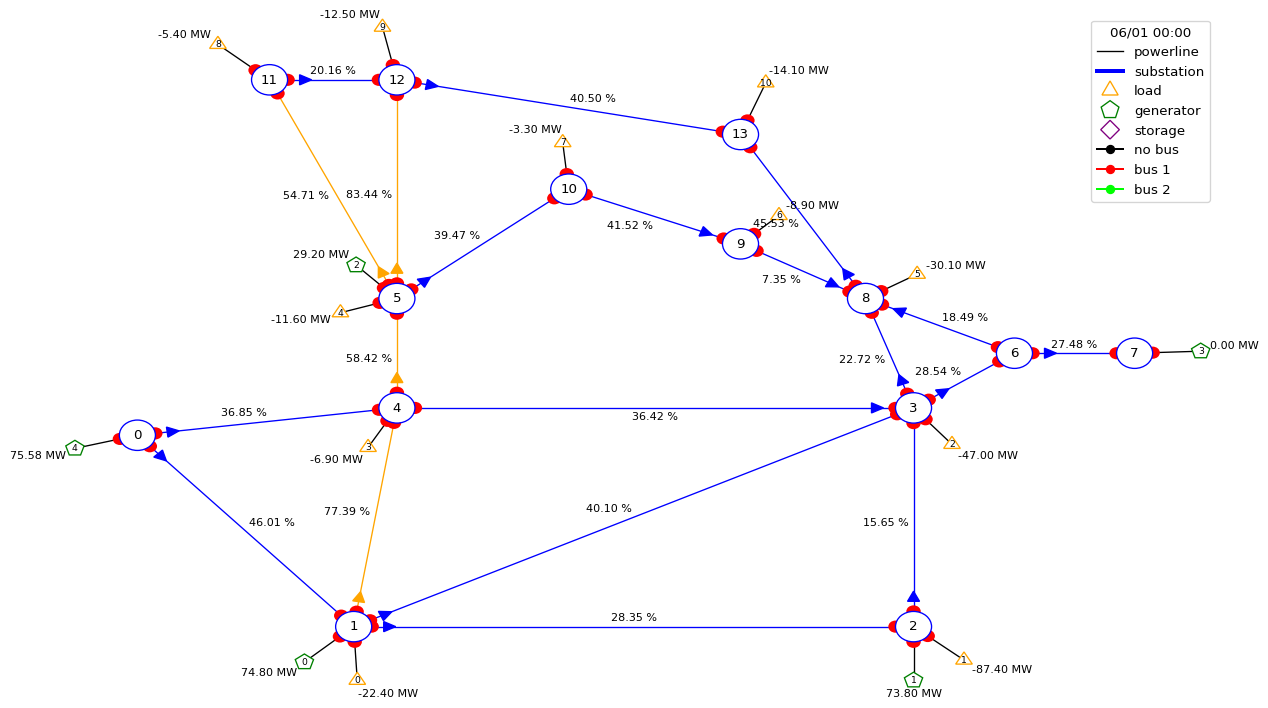

In [13]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
_ = plot_helper.plot_obs(obs)

#### i) connectivity matrix

the `connectivity matrix` which has as many rows / columns as the number of elements in the powergrid (remember that an element is either an end of a powerline, or a generator or a load) and that tells if 2 elements are connected to one another or not:

$$
\left\{
\begin{aligned}
\text{conn mat}[i,j] = 0 & ~\text{element i and j are NOT connected to the same bus}\\
\text{conn mat}[i,j] = 1 & ~\text{element i and j are connected to the same bus, or i and j are both ends of the same powerline}\\
\end{aligned}
\right.
$$

**NB** If two objects are not connected at the same substation, they are necessarily not connected together, except if these elements are the two side of the same powerline.

In [14]:
# if "as_csr_matrix" is set to True, then the result will be given as a csr scipy sparse matrix
mat = obs.connectivity_matrix(as_csr_matrix=False)
mat

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

And if you want to know to which object a given element is connected you can do the following (we take the exemple of trying to recover to which element load 5 is connected)

In [15]:
load_id = 5
which_connected = mat[obs.load_pos_topo_vect[load_id]] == 1
obs.grid_objects_types[which_connected,]

array([[ 8, -1, -1, 10, -1, -1],
       [ 8, -1, -1, 11, -1, -1],
       [ 8, -1, -1, -1, 16, -1],
       [ 8, -1, -1, 19, -1, -1],
       [ 8,  5, -1, -1, -1, -1]])

This will give you a matrix with as many rows as the number of elements that are connected to the element (in this case 5) with:
- the first column indicate the substation. All the objects connected to a given element necessarily belong to the same substation, in our example substation 8.
- the second column encodes for "load". If there is a "-1" it means the element is NOT a load, otherwise it gives the load. Here, looking at the last row, when can know that currently load 5 is... connected to load 5. It will always be the case, except if the element is disconnected of course.
- the third column encodes for "generator". In this case, all this column is "-1" it means the load 5 is not currently directly connected to a generator.
- fourth column encodes for "origin side of powerline". Here we see that our load 5 is connected to powerline (origin side) with ids 10, 11 and 19
- fifth column encodes for "extremity side of powerline". We can see that our load 5 is connecte to powerline (extremity side) 16
- finally last (sixth) column encodes for storage units. This load 5 is not directly connected to any storage unit here. 

You can check that everything is consistent with the plot above.

**Advantages**: 

    - has always the same dimension, regardless of the topology of the powergrid
    - binary matrix
    - all elements are represented and easily accessible
    - symmetric matrix
    
**Drawbacks**:

    - do not contain any information regarding the flows, generations, loads, storage units etc.
    - large matrix
    
#### ii) bus connectivity matrix

Another representation of the "graph" of the powergrid is through "bus-bus" matrix, that says if at least one powerline connect two bus together or not. 

In grid2op this is called "bus_connectivity_matrix". 

This `bus connectivity matrix` has as many rows / columns as the number of active buses of the powergrid. It should be understood as follows:

$$
\left\{
\begin{aligned}
\text{bus conn mat}[i,j] = 0 & ~\text{if no powerline connects bus i to bus j}\\
\text{bus conn mat}[i,j] = 1 & ~\text{if at least one powerline connects bus i to bus j (or i == j)}\\
\end{aligned}
\right.
$$

In [16]:
obs.bus_connectivity_matrix(as_csr_matrix=False)

array([[1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.]],
      dtype=float32)

**Advantages**: 

- "small" matrix
- binary matrix
- symmetric matrix
    
**Drawbacks**:

- do not contain any information regarding the flows, generations, loads, storage units etc.
- it's not easy to know which powerline connects which buses
- it's not easy to know which element is connected to which buses (though the `obs.bus_connectivity_matrix(return_lines_index=True)` might help in this case)
- its dimension changes: you can have 2, or 1 bus at any given substation.
    
#### iii) "flow bus" matrix
Finally, you can introduce informations about flows (*eg* label) on your graph.

This "flow bus matrix" has the following properties:

- like the above "bus connectivity matrix" it has as many rows / columns as the number of different bus on a power
- the diagonal coefficients are the power injected at this bus, which is defined at the sum of the generators connected at this bus minus the sum of the loads connected at this bus
- the non diagonal coefficient `[i, j]` (i different from j then) is the amount of power flowing from bus i to bus j.

In grid2op, you can do the following:

In [17]:
mat, (load_bus, gen_bus, stor_bus, lor_bus, lex_bus) = obs.flow_bus_matrix(active_flow=True, as_csr_matrix=False)
mat, (load_bus, gen_bus, stor_bus, lor_bus, lex_bus) = obs.flow_bus_matrix(active_flow=True, as_csr_matrix=False)
mat

bus_shunt: [0 1 2 3 4 5 6 7 8]
bus_shunt: [0 1 2 3 4 5 6 7 8]


array([[ 7.5578995e+01, -4.0707798e+01,  0.0000000e+00,  0.0000000e+00,
        -3.4871201e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 4.0375103e+01,  5.2400002e+01, -2.5377020e+01, -3.7496193e+01,
        -2.9901894e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  2.5078886e+01, -1.3599998e+01, -1.1478888e+01,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  3.6722034e+01,  1.1335417e+01, -4.7000000e+01,
         3.3143944e+01,  0.0000000e+00, -2.1781700e+01,  0.0000000e+00,
        -1.2419695e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.00

Let's dive a bit on the arguments there:

- `mat` is the flow bus matrix
- `load_bus` indicates for each load, to which bus it is connected
- `gen_bus` indicates for each generator, to which bus it is connected
- `stor_bus` indicates for each load, to which bus it is connected
- `lor_bus` indicates for each line (origin side), to which bus it is connected
- `lex_bus` indicates for each line (extremity side), to which bus it is connected

Let's take the same example as above with the load id 5.

In [18]:
load_id = 5
this_load_bus = load_bus[load_id]
lines_or_id = np.where(lor_bus == this_load_bus)[0]
lines_ex_id = np.where(lex_bus == this_load_bus)[0]
line_id = lines_or_id[0]
print(f"The load {load_id} absorbs: {obs.load_p[load_id]:.2f}MW")
print(f"It is connected to the bus id {this_load_bus} of the matrix")
print(f"And we can see the diagonal coefficient of the \"flow bus matrix\" "\
      f"at this bus is: {mat[this_load_bus,this_load_bus]:.2f}")
print(f"Also we can see that powerlines {lines_or_id} have their origin side connected at this bus.")
print(f"And powerlines {lines_ex_id} have their extremity side connected at this bus.")
print(f"And, for example, if we look at powerline {line_id}, that connects bus {lor_bus[line_id]} "\
      f"to bus {lex_bus[line_id]} we can see that:")
print(f"The flow from bus {lor_bus[line_id]} to {lex_bus[line_id]} is "\
      f"{mat[lor_bus[line_id], lex_bus[line_id]]:.2f}MW")
print(f"For information, the flow at the origin side of this line {line_id} is {obs.p_or[line_id]:.2f}MW. "\
      f"And this is not a coincidence.")
print()
print(f"Also, we want to emphasize that this matrix is NOT symmetrical, for example:")
print(f"\t the power from bus {lor_bus[line_id]} to {lex_bus[line_id]} is "\
      f"{mat[lor_bus[line_id], lex_bus[line_id]]:.5f} MW")
print(f"\t the power from bus {lex_bus[line_id]} to {lor_bus[line_id]} is "\
      f"{mat[lex_bus[line_id], lor_bus[line_id]]:.5f} MW")

The load 5 absorbs: 30.10MW
It is connected to the bus id 8 of the matrix
And we can see the diagonal coefficient of the "flow bus matrix" at this bus is: -30.10
Also we can see that powerlines [10 11 19] have their origin side connected at this bus.
And powerlines [16] have their extremity side connected at this bus.
And, for example, if we look at powerline 10, that connects bus 8 to bus 9 we can see that:
The flow from bus 8 to 9 is 0.71MW
For information, the flow at the origin side of this line 10 is -0.71MW. And this is not a coincidence.

Also, we want to emphasize that this matrix is NOT symmetrical, for example:
	 the power from bus 8 to 9 is 0.71049 MW
	 the power from bus 9 to 8 is -0.71064 MW


So you can see that the power from a bus to another is signed (if it's positive from 8 to 9 it means that the flow is going from 9 to 8: power is injected at bus 8 from bus 9)

And also, the two values (power injected at one side, from another) do not sum at 0. This is because there are losses on the grid, mainly due to Joule's effect.

**Advantages**: 

- "small" matrix
- contain lots of information regarding the flows, generators, loads, storage units etc.

**Drawbacks**:

- it's not easy to know which powerline connects which buses, even though the "lor_bus", "lex_bus", "stor_bus" etc. can be used to retrieve it [bus in any case it will be agregated]
- it's not easy to know which elements are connected to which others
- its dimension changes: you can have 2, or 1 bus at any given substation.
- real number matrix
- non symmetric matrix

**NB** The power in alternative current contains two dimension called "active" and "reactive". We detailed here the example of the "active flow" matrix that is accessed with `obs.flow_bus_matrix(active_flow=True)` (active flows uses `obs.p_or`, `obs.p_ex`, `obs.load_p`, `obs.gen_p` and `obs.storage_power`). You can retrieve the "reactive flow" matrix with `obs.flow_bus_matrix(active_flow=False)` (reactive flows uses `obs.q_or`, `obs.q_ex`, `obs.load_q`, `obs.gen_q` and nothing for the storage reactive power).

#### iv) networkx graph

Lastly, the grid2op framework also offers the possibility to "convert" a given observation as a graph (representing as a networkx graph).

This graph has the following properties:
- it counts as many nodes as the number of buses of the grid
- it counts less edges than the number of lines of the grid (two lines connecting the same buses are "merged" into one single edges)
- nodes have attributes:
- edges have attributes:

An example is given in:

In [44]:
import networkx
mat, (load_bus, gen_bus, stor_bus, lor_bus, lex_bus) = obs.flow_bus_matrix(active_flow=True, as_csr_matrix=True)
mat.setdiag(0.)
graph = networkx.from_scipy_sparse_matrix(mat, edge_attribute="p_or")
graph.edges(data=True)

bus_shunt: [0 1 2 3 4 5 6 7 8]
  (0, 0)	0.0
  (0, 1)	-40.707798
  (0, 4)	-34.8712
  (1, 0)	40.375103
  (1, 1)	0.0
  (1, 2)	-25.37702
  (1, 3)	-37.496193
  (1, 4)	-29.901894
  (2, 1)	25.078886
  (2, 2)	0.0
  (2, 3)	-11.478888
  (3, 1)	36.722034
  (3, 2)	11.335417
  (3, 3)	0.0
  (3, 4)	33.143944
  (3, 6)	-21.7817
  (3, 8)	-12.419695
  (4, 0)	34.250973
  (4, 1)	29.420454
  (4, 3)	-33.290043
  (4, 4)	0.0
  (4, 5)	-23.481386
  (5, 4)	23.481386
  (5, 5)	0.0
  (5, 10)	-13.214905
  :	:
  (6, 7)	-1.0214052e-14
  (6, 8)	-21.7817
  (7, 6)	1.0658141e-14
  (7, 7)	0.0
  (8, 3)	12.419695
  (8, 6)	21.7817
  (8, 8)	0.0
  (8, 9)	0.7104877
  (8, 13)	-4.811883
  (9, 8)	-0.7106372
  (9, 9)	0.0
  (9, 10)	9.610637
  (10, 5)	13.008661
  (10, 9)	-9.708661
  (10, 10)	0.0
  (11, 5)	7.9566593
  (11, 11)	0.0
  (11, 12)	-2.5566595
  (12, 5)	19.48814
  (12, 11)	2.5411038
  (12, 12)	0.0
  (12, 13)	-9.529244
  (13, 8)	4.7650456
  (13, 12)	9.334954
  (13, 13)	0.0


EdgeDataView([(0, 0, {'p_or': 0.0}), (0, 1, {'p_or': 40.375103}), (0, 4, {'p_or': 34.250973}), (1, 1, {'p_or': 0.0}), (1, 2, {'p_or': 25.078886}), (1, 3, {'p_or': 36.722034}), (1, 4, {'p_or': 29.420454}), (2, 2, {'p_or': 0.0}), (2, 3, {'p_or': 11.335417}), (3, 3, {'p_or': 0.0}), (3, 4, {'p_or': -33.290043}), (3, 6, {'p_or': 21.7817}), (3, 8, {'p_or': 12.419695}), (4, 4, {'p_or': 0.0}), (4, 5, {'p_or': 23.481386}), (5, 5, {'p_or': 0.0}), (5, 10, {'p_or': 13.008661}), (5, 11, {'p_or': 7.9566593}), (5, 12, {'p_or': 19.48814}), (6, 6, {'p_or': 0.0}), (6, 7, {'p_or': 1.0658141e-14}), (6, 8, {'p_or': 21.7817}), (7, 7, {'p_or': 0.0}), (8, 8, {'p_or': 0.0}), (8, 9, {'p_or': -0.7106372}), (8, 13, {'p_or': 4.7650456}), (9, 9, {'p_or': 0.0}), (9, 10, {'p_or': -9.708661}), (10, 10, {'p_or': 0.0}), (11, 11, {'p_or': 0.0}), (11, 12, {'p_or': 2.5411038}), (12, 12, {'p_or': 0.0}), (12, 13, {'p_or': 9.334954}), (13, 13, {'p_or': 0.0})])

In [43]:
mat[0,7]

0.0

#### c) Some other handy methods

The observation can be converted to / from a flat numpy array. This function is useful for interacting with machine learning libraries or to store it, but it probably makes it less readable for a human. The function proceeds by stacking all the features mentionned above in a single `numpy.float64` vector.

In [21]:
vector_representation_of_observation = obs.to_vect()
vector_representation_of_observation

array([ 2.01900000e+03,  1.00000000e+00,  6.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.00000000e+00,  7.48000031e+01,  7.38000031e+01,
        2.92000008e+01,  0.00000000e+00,  7.55789948e+01,  1.93299427e+01,
        7.42750473e+01,  4.39600983e+01,  2.49400768e+01, -1.71059189e+01,
        1.42100006e+02,  1.42100006e+02,  2.20000000e+01,  1.32000008e+01,
        1.42100006e+02,  2.23999996e+01,  8.74000015e+01,  4.70000000e+01,
        6.90000010e+00,  1.16000004e+01,  3.01000004e+01,  8.89999962e+00,
        3.29999995e+00,  5.40000010e+00,  1.25000000e+01,  1.41000004e+01,
        1.56000004e+01,  6.09000015e+01,  3.22000008e+01,  4.90000010e+00,
        8.10000038e+00,  2.11000004e+01,  6.19999981e+00,  2.40000010e+00,
        3.79999995e+00,  8.69999981e+00,  1.00000000e+01,  1.42100006e+02,
        1.42100006e+02,  1.38843201e+02,  1.39638245e+02,  2.20000000e+01,
        2.10462112e+01,  2.10525150e+01,  2.14346600e+01,  2.15758610e+01,
        2.14234734e+01,  

An observation can be copied, of course:

In [22]:
obs2 = obs.copy()

Or reset:

In [23]:
obs2.reset()
print(obs2.gen_p)

[nan nan nan nan nan]


Or loaded from a vector:

In [24]:
obs2.from_vect(vector_representation_of_observation)
obs2.gen_p

array([74.8     , 73.8     , 29.2     ,  0.      , 75.578995],
      dtype=float32)

It is also possible to assess whether two observations are equal or not:

In [25]:
obs == obs2

False

#### d) Simulate

As opposed to most RL problems, in this framework we add the possibility to "simulate" the impact of a possible action on the power grid. This helps calculating roll-outs in the RL setting, and can be close to "model-based" reinforcement learning approaches (except that nothing more has to be learned).

This "simulate" method uses the available forecast data (forecasts are made available by the same way we loaded the data here, with the class `GridStateFromFileWithForecasts`. For this class, only forecasts for 1 time step are provided, but this might be adapted in the future).

Note that this `simulate` function can use a different simulator than the one used by the Environment. Fore more information, we encourage you to read the official documentation, or if it has been built locally (recommended), to consult [this page](https://grid2op.readthedocs.io/en/latest/observation.html#grid2op.Observation.Observation.simulate).

This function will:

1. apply the forecasted injection on the powergrid
2. run a powerflow with the decidated `simulate` powerflow simulator
3. return:
    1. the anticipated observation (after the action has been taken)
    2. the anticipated reward (of this simulated action)
    3. whether or not there has been an error
    4. some more informations
    
From a user point of view, this is the main difference with the previous [pypownet](https://github.com/MarvinLer/pypownet) framework. In pypownet, this "simulation" used to be performed directly by the environment, thus giving direct access of the environment's future data to the agent, which could break the RL framework since the agent is only supposed to know about the current state of the environment (it was not the case in the first edition of the Learning to Run A Power Network as the Environment was fully observable). In grid2op, the simulation is now performed from the current state of the environment and it is imperfect since it does not have access to future information.

Here is an example of some features of the observation, in the current state and in the simulated next state :

In [26]:
do_nothing_act = env.action_space({})
obs_sim, reward_sim, is_done_sim, info_sim = obs.simulate(do_nothing_act)

In [27]:
obs.gen_p

array([74.8     , 73.8     , 29.2     ,  0.      , 75.578995],
      dtype=float32)

In [28]:
obs_sim.gen_p

array([75.8     , 74.2     , 29.3     ,  0.      , 73.846016],
      dtype=float32)

#### e) obs + act

In gri2op >= 1.5 we also introduced a method that can be used to rapidly assess what would be the effect of a given "action" (see next notebook for a more detailed explanation of the actions) on the grid.

To use it, you can use the `obs.connectivity_matrix()` and `obs.bus_connectivity_matrix()` function combined with the grid2op `obs + act` implementation.

An example is given here:

In [29]:
action_description = {}
act = env.action_space(action_description)
resulting_partial_obs = obs + act
resulting_partial_obs.connectivity_matrix()

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

**NB** This is not commutative: `obs + act` is not the same as `act + obs` (the later will crash by the way).

**NB** This `obs + act` method is much faster than the `env.step(act)` method or the `obs.simulate(act)` method, but the resulting "partial observation" is not complete at all. For example, it do not contains any information on the flows, nor the loads or generators etc. do not have anything regaring the time (date, hour of day etc.). We recommend to use it only combined with the `partial_obs.connectivity_matrix()` or `partial_obs.bus_connectivity_matrix()`

## II) Taking actions based on the observation

In this section we will make our first *Agent* that will act based on these observations.

All *Agents* must derive from the grid2op.Agent class. The main function to implement for the Agents is the "act" function (more information can be found on the official documentation or [here](https://grid2op.readthedocs.io/en/latest/agent.html) ). 

Basically, the Agent receives a reward and an observation, and chooses a new action. Some different *Agents* are pre-defined in the `grid2op` package. We won't talk about them here (for more information, see the documentation or the [Agent.py](grid2op/Agent/Agent.py) file), but rather we will make a custom Agent.

This *Agent* will select among:

- doing nothing 
- disconnecting the powerline having the higher relative flows
- reconnecting a powerline disconnected
- disconnecting the powerline having the lower relative flows

by using `simulate` on the corresponding actions, and choosing the one that has the highest predicted reward.

Note that this kind of Agent is not particularly smart and is given only as an example.

More information about the creation / manipulation of *Action* will be given in the notebook [2_Action_GridManipulation](2_Action_GridManipulation.ipynb)

In [30]:
from grid2op.Agent import BaseAgent
import numpy as np
import pdb


class MyAgent(BaseAgent):
    def __init__(self, action_space):
        # python required method to code
        BaseAgent.__init__(self, action_space)
        self.do_nothing = self.action_space({})
        self.print_next = False
        
    def act(self, observation, reward, done=False):
        i_max = np.argmax(observation.rho)
        new_status_max = np.zeros(observation.rho.shape, dtype=int)
        new_status_max[i_max] = -1
        act_max = self.action_space({"set_line_status": new_status_max})
        
        i_min = np.argmin(observation.rho)
        new_status_min = np.zeros(observation.rho.shape, dtype=int)
        if observation.rho[i_min] > 0:
            # all powerlines are connected, i try to disconnect this one
            new_status_min[i_min] = -1
            act_min = self.action_space({"set_line_status": new_status_min})
        else:
            # at least one powerline is disconnected, i try to reconnect it
            new_status_min[i_min] = 1
#             act_min = self.action_space({"set_status": new_status_min})
            act_min = self.action_space({"set_line_status": new_status_min,
                                         "set_bus": {"lines_or_id": [(i_min, 1)], "lines_ex_id": [(i_min, 1)]}})
    
        _, reward_sim_dn, *_ = observation.simulate(self.do_nothing)
        _, reward_sim_max, *_ = observation.simulate(act_max)
        _, reward_sim_min, *_ = observation.simulate(act_min)
            
        if reward_sim_dn >= reward_sim_max and reward_sim_dn >= reward_sim_min:
            self.print_next = False
            res = self.do_nothing
        elif reward_sim_max >= reward_sim_min:
            self.print_next = True
            res = act_max
            print(res)
        else:
            self.print_next = True
            res = act_min
            print(res)
        return res

We compare this Agent with the `Donothing` agent (already coded) on the 3 episodes made available with this package. To make this comparison more interesting, it's better to use the L2RPN rewards (`L2RPNReward`).

In [31]:
from grid2op.Runner import Runner
from grid2op.Agent import DoNothingAgent
from grid2op.Reward import L2RPNReward
from grid2op.Chronics import GridStateFromFileWithForecasts

max_iter = 10  # to make computation much faster we will only consider 50 time steps instead of 287
runner = Runner(**env.get_params_for_runner(),
                agentClass=DoNothingAgent
               )
res = runner.run(nb_episode=1, max_iter=max_iter)

print("The results for DoNothing agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for DoNothing agent are:
	For chronics with id 000
		 - cumulative reward: 11076.768555
		 - number of time steps completed: 10 / 10


In [32]:
runner = Runner(**env.get_params_for_runner(),
                agentClass=MyAgent
               )
res = runner.run(nb_episode=1, max_iter=max_iter)
print("The results for the custom agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for the custom agent are:
	For chronics with id 000
		 - cumulative reward: 11076.768555
		 - number of time steps completed: 10 / 10


As we can see, both agents obtain the same score here, but there would be a difference if we didn't limit the episode length to 10 time steps.

**NB** Disabling the time limit for the episode can be done by setting `max_iter=-1` in the previous cells. Here, setting `max_iter=10` is only done so that this notebook can run faster, but increasing or disabling the time limit would allow us to spot differences in the agents' performances.

The same can be done for the `PowerLineSwitch` agent :

In [33]:
from grid2op.Agent import PowerLineSwitch
runner = Runner(**env.get_params_for_runner(),
                agentClass=PowerLineSwitch
               )
res = runner.run(nb_episode=1, max_iter=max_iter)
print("The results for the PowerLineSwitch agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for the PowerLineSwitch agent are:
	For chronics with id 000
		 - cumulative reward: 2164.011719
		 - number of time steps completed: 3 / 10


TODO doc: new possibility to retrieve directly the "run" of the episode